## Part 1

In [139]:
import pandas as pd
import numpy as np
import ast
import re
from collections import defaultdict

### load business data and review data

In [140]:
trainSize=10000
business_train = pd.read_json('..//data//business_train.json',orient = 'records',lines = True)
review_train=pd.read_json('..//data//review_train.json',orient='records',lines=True,chunksize=trainSize)

### first look at the data structure of business_train

category:

In [141]:
business_train.categories.iloc[:5]

0                                    Golf, Active Life
1                    Sushi Bars, Restaurants, Japanese
2                        Insurance, Financial Services
3    Plumbing, Shopping, Local Services, Home Servi...
4                           Beauty & Spas, Hair Salons
Name: categories, dtype: object

In [142]:
businessCategory=business_train.categories.map(lambda x: x.split(',') if x!=None else [])
res=defaultdict(int)
for i in businessCategory:
    for j in i:
        res[j]+=1

res=sorted(res.items(),key=lambda x:x[1],reverse=True)

By term appearance frequency, we have:

In [143]:
for i in res[:10]:
    print("{} appears {} times in the category column.".format(i[0],i[1]))
    


 Restaurants appears 33024 times in the category column.
 Shopping appears 19337 times in the category column.
 Food appears 17582 times in the category column.
Restaurants appears 14482 times in the category column.
 Home Services appears 11677 times in the category column.
 Beauty & Spas appears 10936 times in the category column.
 Health & Medical appears 10210 times in the category column.
 Local Services appears 8449 times in the category column.
 Nightlife appears 8242 times in the category column.
 Bars appears 7334 times in the category column.


In this document, we mainly focus on the Restaurants, the analysis logic can also be applied on other types of business entities.

### filter all the Restaurants

In [144]:
business_train=business_train[business_train.categories.map(lambda x:"Restaurants" in x if x else False)]

### preserve business_id, stars columns and save it to local json files

In [145]:
# count=2
# res=next(review_train).iloc[:,[0,2]]
# for reviewTrainChunk in review_train:
#     print("processing {} th chunk ...".format(count))
#     res=res.append(reviewTrainChunk.iloc[:,[0,2]])
#     count+=1
# print("finished")

In [146]:
# res.shape
# res.columns

# res=res.groupby('business_id',as_index=False).mean()

# res.to_json("average_star_by_shops.json",orient='records')

In [147]:
shop_stars=pd.read_json("average_star_by_shops.json",orient="records")

### Extract nested json data from business attribute data

In [148]:
def nestedValue(x:str):
    """judge if a string contains nested json information"""
    return re.match(u'{.*}',x)

### first extract the column names from nested json
colnames=[]
for attribute in business_train.attributes:
    if attribute==None:
        continue
    for key,value in attribute.items():
        if not nestedValue(value):
            colnames.append(key)
        else:
            for nestKey,nestValue in ast.literal_eval(value).items():
                colnames.append(nestKey)
colnames=set(colnames)

### second extract the value from nested json file
res=defaultdict(list)
count=0
for attribute in business_train.attributes:
    
    
    for i in colnames:
        res[i].append(None)
    if attribute==None:
        count+=1
        continue
    for key,value in attribute.items():
        if not nestedValue(value):
            res[key][count]=value
        else:
            for nestKey,nestValue in ast.literal_eval(value).items():
                res[nestKey][count]=nestValue
            
        
    count+=1 

attributeTrain=pd.DataFrame(res)

attributeTrain.shape

attributeTrain['business_id']=business_train.business_id.tolist()

### join business data and review rating on business_id

In [149]:
attributeTrain=attributeTrain.join(shop_stars.set_index('business_id'),on="business_id",how='left')

### data cleaning, drop columns with many NAs, convert string to category 

In [150]:
attributeTrainReduced=attributeTrain.dropna(thresh=len(attributeTrain)*0.8, axis=1)

attributeTrainReduced=attributeTrainReduced.drop("business_id",axis=1);

attributeTrainReduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47506 entries, 0 to 47505
Data columns (total 9 columns):
RestaurantsPriceRange2      41706 non-null object
RestaurantsTakeOut          41884 non-null object
RestaurantsReservations     40332 non-null object
RestaurantsGoodForGroups    40791 non-null object
RestaurantsDelivery         39863 non-null object
RestaurantsAttire           38879 non-null object
OutdoorSeating              38660 non-null object
GoodForKids                 40545 non-null object
stars                       47506 non-null float64
dtypes: float64(1), object(8)
memory usage: 3.3+ MB


In [151]:
for colName in attributeTrainReduced.columns[:-1]:
    attributeTrainReduced[colName]=attributeTrainReduced[colName].astype('category')

In [152]:
attributeTrainReduced.iloc[:,0].values

[2, 1, 2, 2, 1, ..., 2, 2, NaN, 1, 3]
Length: 47506
Categories (5, object): [1, 2, 3, 4, None]

### try fit a simple linear regression

In [153]:
pd.get_dummies(attributeTrainReduced).iloc[:5,:]

,stars,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_None,RestaurantsTakeOut_False,RestaurantsTakeOut_None,RestaurantsTakeOut_True,RestaurantsReservations_False,...,RestaurantsAttire_None,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,GoodForKids_False,GoodForKids_None,GoodForKids_True
0,4.073034,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,2.894737,1,0,0,0,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,1
2,4.333333,0,1,0,0,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,1
3,4.097561,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,4.243243,1,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1


In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(attributeTrainReduced).iloc[:,1:],pd.get_dummies(attributeTrainReduced).iloc[:,0],  random_state=0)

In [155]:
modelSlr = LinearRegression().fit(X_train, y_train)
pred=modelSlr.predict(X_test)
print("the score(rmse) is {}".format(np.sqrt(mean_squared_error(pred,y_test))))

the score(rmse) is 0.772897920927657


### round the rating value and use a multioutcome logistic regression

In [156]:
# here, we need to make continuous ylabel to be categorical variable
y_train_class=np.round(y_train)
y_test_class=np.round(y_test)
from sklearn.linear_model import LogisticRegression

modelLr=LogisticRegression(multi_class='multinomial',solver='newton-cg')
modelLr.fit(X_train,y_train_class)
pred=modelLr.predict(X_test)
print("the score is {}".format(mean_squared_error(pred,y_test_class)))

the score is 1.0063989222867729


### Linear Discriminant Analysis  (different from latent dirichlet allocation topic model)
Here, we would like to select a few dimensions, each dimension is a linear combination of the business attribute, that separate the most of five classes.

In [157]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
modelLda = LinearDiscriminantAnalysis(n_components=2)

modelLda.fit(X_train,y_train_class)
temp=modelLda.transform(X_test)
print(temp)

modelLda.fit(X_train,y_train_class)
pred=modelLda.predict(X_test)
print("the score(rmse) is {}".format(np.sqrt(mean_squared_error(pred,y_test_class))))

[[-0.65605133  1.08297415]
 [-1.38859902  1.62475809]
 [-0.09525673  1.21068002]
 ...
 [ 0.95767289  0.74735597]
 [-0.44731994  1.20638682]
 [ 1.09497859  0.19703957]]
the score(rmse) is 1.0115939836754513


explained variance ratio (first two components): [0.69930716 0.21894569]


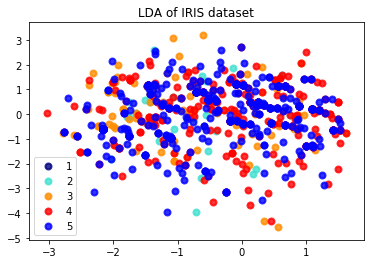

In [158]:
import matplotlib.pyplot as plt
X_test_transform= modelLda.transform(X_test)
target_names=[1,2,3,4,5]
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(modelLda.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','red','blue']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2,3,4], target_names):
    plt.scatter(X_test_transform[y_test == i, 0], X_test_transform[y_test == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [159]:
for i,j in zip([1,2],[3,4]):
    print(i,j)

1 3
2 4


### use randomforest to have a glimpse at feature importance

In [160]:
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline            

modelRfc = RandomForestClassifier()
modelRfc.fit(X_train, y_train_class)

pred=modelRfc.predict(X_test)
print("the score(rmse) is {}".format(np.sqrt(mean_squared_error(pred,y_test_class))))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


the score(rmse) is 1.0170724189871352


the prediction is better than logistic regression

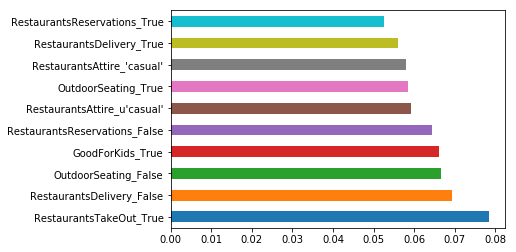

In [161]:
pd.Series(modelRfc.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh')

some variables actually make sense, so we extract a single tree from the forest to visualize it.

In [162]:
# from sklearn.tree import export_graphviz
# # Extract single tree
# estimator = modelRfc.estimators_[5]

# # Export to dot file
# export_graphviz(estimator, 
#                 out_file='tree.dot', 
#                 feature_names = X_train.columns,
                
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
# # Convert to png
# import os
# os.system('dot -Tpng tree.dot -o tree.png')

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

### check the meaning of each variable and do variable selection

In [163]:
for i in attributeTrainReduced.columns[:-1]:
    print("--------------------------------------------------------------------")
    category=pd.unique(attributeTrainReduced[i])
    if (True in category and False in category) or ("True" in category and "False" in category):
        for subClass in category:
            subClassRate=round(np.sum(attributeTrainReduced[i]==subClass)/attributeTrainReduced.shape[0]*100,2)
            subClassStar=round(np.mean(attributeTrainReduced.stars[attributeTrainReduced[i]==subClass]),2)
            print("For {},{}% shops are {}, the average ratings are {}".format(i,subClassRate,subClass,subClassStar))
        if np.mean(attributeTrainReduced.stars[attributeTrainReduced[i].isin([True,"True"])])>np.mean(attributeTrainReduced.stars[attributeTrainReduced[i].isin(["False",False])]):
            print("Shops have True value for {} tend to have higher ratings".format(i))
        else:
            print("Shops have False value for {} tend to have higher ratings".format(i))
    else:
        for subClass in category:
            subClassRate=round(np.sum(attributeTrainReduced[i]==subClass)/attributeTrainReduced.shape[0]*100,2)
            subClassStar=round(np.mean(attributeTrainReduced.stars[attributeTrainReduced[i]==subClass]),2)
            print("For {},{}% shops are {}, the average ratings are {}".format(i,subClassRate,subClass,subClassStar))



--------------------------------------------------------------------
For RestaurantsPriceRange2,46.69% shops are 2, the average ratings are 3.48
For RestaurantsPriceRange2,35.3% shops are 1, the average ratings are 3.39
For RestaurantsPriceRange2,4.85% shops are 3, the average ratings are 3.61
For RestaurantsPriceRange2,0.0% shops are nan, the average ratings are nan
For RestaurantsPriceRange2,0.87% shops are 4, the average ratings are 3.65
For RestaurantsPriceRange2,0.08% shops are None, the average ratings are 3.1
--------------------------------------------------------------------
For RestaurantsTakeOut,82.38% shops are True, the average ratings are 3.44
For RestaurantsTakeOut,5.69% shops are False, the average ratings are 3.58
For RestaurantsTakeOut,0.0% shops are nan, the average ratings are nan
For RestaurantsTakeOut,0.09% shops are None, the average ratings are 3.46
Shops have False value for RestaurantsTakeOut tend to have higher ratings
----------------------------------------

Conclusion:

RestaurantsTakeOut: False is better

touristy: False is better

BusinessAcceptsCreditCards : False is better (why)

RestaurantsAttire: formal is better

NoiseLevel: quiet is better

### PCA

In [164]:
import numpy as np
from sklearn.decomposition import PCA
modelPca = PCA(n_components=2)
modelPca.fit(X_train)
print(modelPca.components_.shape)
print(modelPca.explained_variance_ratio_)
print(modelPca.components_[0,:])

(2, 30)
[0.19542214 0.16214315]
[-4.73349831e-01  3.27634924e-01  5.85755551e-02  1.09853255e-02
  4.18435124e-05  6.48478835e-02  5.64808980e-04 -1.72890765e-01
 -5.18322876e-01  2.50438943e-04  4.10821387e-01 -8.80159145e-02
  3.17116102e-04 -4.91836219e-03 -1.00370346e-01  2.99197606e-04
 -6.99740097e-03 -1.03177970e-01  1.12096436e-02  3.87376378e-04
  4.78235292e-05 -3.92299512e-02  2.50621110e-02  1.57780567e-04
 -2.30259074e-01  8.64714737e-05  1.49728591e-01  1.47540260e-01
  2.02240416e-04 -2.55880465e-01]


### Latent dirichlet allocation for review topic extraction based on tfidf vector

First step is to do data preprocessing. See our Tfidf.ipynb for more details. To make things simple, we import some packages here. When submitting the final version, pay attention not to use these packages !

In [165]:
# load supported packages
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ykh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

load reviews about restaurants.

In [166]:
# load a small fractio of review data
reviewTrain=next(review_train)

# make sure all reviews are about restaurants, map is a filter function to select reviews based on business_id
reviewTrain=reviewTrain[reviewTrain.business_id.map(lambda x:x in business_train.business_id)]
print("the total number of reviews we use here is {}.".format(reviewTrain.shape[0]))

the total number of reviews we use here is 2718.


do data cleaning.

In [167]:
stemmer = SnowballStemmer('english') # use english
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text): # tokenize
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result
reviewProcessed = reviewTrain.text.map(preprocess)

after data preprocessing ... looks like this.

In [168]:
reviewProcessed[:10]

5     [admit, excit, go, tavolta, food, snob, group,...
7     [place, go, hill, clear, staff, food, qualiti,...
14    [wrong, place, pasta, pizza, amaz, high, quali...
15    [great, lunch, today, staff, help, assist, sel...
16    [huge, slim, open, texa, year, live, place, di...
18    [food, good, price, reason, exact, restaur, li...
19    [pick, meat, planet, chef, mexican, style, dis...
28    [best, chines, resto, high, recommend, star, s...
34    [satisfi, freez, yogurt, crave, kiwispoon, inv...
36    [dinner, bellagio, buffet, night, servic, serv...
Name: text, dtype: object

do further data cleaning.

In [169]:
reviewDict= gensim.corpora.Dictionary(reviewProcessed)
reviewDict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) # filter extreme values, which occurs very few

In [178]:
reviewCorpus = [reviewDict.doc2bow(review) for review in reviewProcessed]
reviewCorpus[0];

For example:

In [180]:
reviewFirst=reviewCorpus[0]
for i in range(len(reviewFirst)):
    if i>10:
        print("......")
        break
    print("Word {} (\"{}\") appears {} time.".format(reviewFirst[i][0], 
                                                     reviewDict[reviewFirst[i][0]], 
                                                     reviewFirst[i][1]))

Word 0 ("amaz") appears 1 time.
Word 1 ("check") appears 1 time.
Word 2 ("downtown") appears 3 time.
Word 3 ("food") appears 1 time.
Word 4 ("friend") appears 1 time.
Word 5 ("high") appears 1 time.
Word 6 ("lot") appears 1 time.
Word 7 ("option") appears 1 time.
Word 8 ("owner") appears 1 time.
Word 9 ("peopl") appears 1 time.
Word 10 ("pizza") appears 1 time.
......


Second step is to apply tfidf on text column, and get a tfidf vector.

In [181]:
from gensim import corpora, models

reviewTfidf = models.TfidfModel(reviewCorpus)
reviewTfidfVec=reviewTfidf[reviewCorpus] # convert to tfidf vector 


for review in reviewTfidfVec[0][:10]: # see the tfidf score of the first review
    print(review)


(0, 0.09111189493213412)
(1, 0.1530329875180127)
(2, 0.7271533328550337)
(3, 0.06506638971842466)
(4, 0.08473474213626288)
(5, 0.12599865577840239)
(6, 0.21825747262306103)
(7, 0.17468892580847162)
(8, 0.16201773001731729)
(9, 0.1530329875180127)


Finally, we run LDA using Bags of Words.

In [182]:
# because we have used linear discriminant analysis above, here we call the model modelTopic
modelTopic = gensim.models.LdaMulticore(reviewCorpus, num_topics=5, id2word=reviewDict, passes=2, workers=2)

In [174]:
for index, topic in modelTopic.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(index, topic))

Topic: 0 
Words: 0.021*"place" + 0.017*"food" + 0.017*"good" + 0.016*"like" + 0.012*"time" + 0.010*"servic" + 0.010*"order" + 0.009*"come" + 0.008*"sushi" + 0.008*"go"
Topic: 1 
Words: 0.023*"time" + 0.023*"come" + 0.014*"food" + 0.012*"love" + 0.011*"good" + 0.010*"order" + 0.010*"like" + 0.009*"room" + 0.008*"think" + 0.008*"tell"
Topic: 2 
Words: 0.017*"go" + 0.012*"like" + 0.011*"servic" + 0.010*"time" + 0.009*"know" + 0.009*"call" + 0.008*"need" + 0.008*"love" + 0.008*"say" + 0.007*"food"
Topic: 3 
Words: 0.018*"place" + 0.016*"like" + 0.014*"room" + 0.013*"great" + 0.012*"time" + 0.010*"come" + 0.010*"go" + 0.009*"stay" + 0.008*"vega" + 0.008*"good"
Topic: 4 
Words: 0.028*"food" + 0.025*"good" + 0.017*"chicken" + 0.016*"place" + 0.014*"time" + 0.013*"order" + 0.011*"great" + 0.010*"servic" + 0.010*"like" + 0.010*"delici"
Topic: 5 
Words: 0.031*"food" + 0.019*"time" + 0.017*"place" + 0.016*"great" + 0.013*"friend" + 0.013*"restaur" + 0.012*"servic" + 0.011*"love" + 0.009*"definit"

We cannot manully separate the topics, that's annoying !!!!!!!!!

Why not group by stars first and then do topic modeling under each group? Let's try it. (code are exactly the same, except the input data are different.)

In [175]:
for i in range(1,6):
    print("-----------------------------------------------------------")
    print("The following topic model is based on {} star reviews".format(i))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
    reviewTrainFraction=reviewTrain[reviewTrain.stars==i]
    reviewProcessed = reviewTrainFraction.text.map(preprocess)
    reviewDict= gensim.corpora.Dictionary(reviewProcessed)
    reviewDict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) # filter extreme values, which occurs very few
    reviewCorpus = [reviewDict.doc2bow(review) for review in reviewProcessed]
    reviewCorpus[0]
#     reviewFirst=reviewCorpus[0]
#     for i in range(len(reviewFirst)):
#         print("Word {} (\"{}\") appears {} time.".format(reviewFirst[i][0], 
#                                                          reviewDict[reviewFirst[i][0]], 
#                                                          reviewFirst[i][1]))

    reviewTfidf = models.TfidfModel(reviewCorpus)
    reviewTfidfVec=reviewTfidf[reviewCorpus] # convert to tfidf vector 
#     for review in reviewTfidfVec[0]: # see the tfidf score of the first review
#         print(review)

    modelTopic = gensim.models.LdaMulticore(reviewCorpus, num_topics=3, id2word=reviewDict, passes=2, workers=2)
    for index, topic in modelTopic.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(index, topic))


-----------------------------------------------------------
The following topic model is based on 1 star reviews
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Topic: 0 
Words: 0.027*"food" + 0.026*"say" + 0.020*"come" + 0.020*"place" + 0.020*"go" + 0.018*"tell" + 0.015*"peopl" + 0.015*"tabl" + 0.015*"want" + 0.014*"wait"
Topic: 1 
Words: 0.028*"servic" + 0.026*"like" + 0.025*"custom" + 0.024*"order" + 0.023*"time" + 0.017*"tell" + 0.016*"place" + 0.014*"know" + 0.013*"compani" + 0.013*"food"
Topic: 2 
Words: 0.028*"time" + 0.025*"tell" + 0.024*"go" + 0.023*"order" + 0.022*"come" + 0.018*"servic" + 0.017*"place" + 0.017*"say" + 0.015*"hour" + 0.014*"need"
-----------------------------------------------------------
The following topic model is based on 2 star reviews
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Topic: 0 
Words: 0.042*"food" + 0.041*"place" + 0.041*"time" + 0.032*"go" + 0.029*"good" + 0.025*"restaur" + 0.025*"order" + 0.024*"servic" + 0.022*

Let's see some reviews from 1 star to 5 star, and see if the topic makes some sense.

In [176]:
for index in range(5):
    print("----------------------------------------------------------------------------------------------")
    print(reviewTrain.text[reviewTrain.stars==1].iloc[index])

----------------------------------------------------------------------------------------------
This place has gone down hill.  Clearly they have cut back on staff and food quality

Many of the reviews were written before the menu changed.  I've been going for years and the food quality has gone down hill.

The service is slow & my salad, which was $15, was as bad as it gets.

It's just not worth spending the money on this place when there are so many other options.
----------------------------------------------------------------------------------------------
We had dinner at the Bellagio Buffet last night. The service was OK. Our server was great but kind of forgot about us towards the end of our visit. The food was cold. The only good thing there was the crab legs because they're suppose to be cold and the tacos because it was freshly made. The food was under a single lamp that didn't heat the food at all. We let the server know that the food was cold and he told the manager that was 

### EDA for other business data outside of business attributes

In [177]:
business_train.columns

Index(['attributes', 'business_id', 'categories', 'city', 'hours', 'is_open',
       'latitude', 'longitude', 'name', 'postal_code', 'state'],
      dtype='object')